### KUNAL KISHORE || 22810041

**Note:** 

This notebook generates and edits Excel files for each time block. Please refrain from opening these Excel files (located in the `excel_files` folder) while this notebook is running to avoid potential conflicts or data corruption.


In [1]:
!pip install ortools

In [2]:
import numpy as np
import pandas as pd
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt

import os
import openpyxl

import warnings

warnings.filterwarnings("ignore")

#### READING AND PREPROCESSING GIVEN DATA ("Bid Data.xlsx")


In [3]:
sell_bids = pd.read_excel("Bid Data.xlsx", sheet_name="Sell bids")
buy_bids = pd.read_excel("Bid Data.xlsx", sheet_name="Buy bids")

sell_bids["Type"] ="Sell"
buy_bids["Type"] ="Buy"

In [4]:
sell_bids

,Supplier,Time block,Bid quantity (MWh),Sup Bid Price (INR/MWh),Type
0,AGARTALA GT,1,21.00,2721.0,Sell
1,AKALTARA TPS,1,1800.00,4050.0,Sell
2,AKRIMOTA LIG TPS,1,125.00,2610.0,Sell
3,ALIYAR HPS,1,60.00,6228.0,Sell
4,ALLAIN DUHANGAN HPS,1,192.00,3607.9,Sell
...,...,...,...,...,...
187,ANTA CCPP,12,88.71,3910.0,Sell
188,ANTA CCPP,12,612.80,3910.0,Sell
189,ANUPPUR TPP,12,600.00,3831.0,Sell
190,AURAIYA CCPP,12,111.19,3910.0,Sell


In [5]:
new_col_names = ["Company", "Time Block", "Bid quantity", "Bid Price", "Type"]
current_col_names = sell_bids.columns.tolist()

# Create a dictionary mapping old column names to new column names
rename_dict = dict(zip(current_col_names, new_col_names))

# Rename columns using the dictionary
sell_bids.rename(columns=rename_dict, inplace=True)

# Print the DataFrame to verify the changes
sell_bids

,Company,Time Block,Bid quantity,Bid Price,Type
0,AGARTALA GT,1,21.00,2721.0,Sell
1,AKALTARA TPS,1,1800.00,4050.0,Sell
2,AKRIMOTA LIG TPS,1,125.00,2610.0,Sell
3,ALIYAR HPS,1,60.00,6228.0,Sell
4,ALLAIN DUHANGAN HPS,1,192.00,3607.9,Sell
...,...,...,...,...,...
187,ANTA CCPP,12,88.71,3910.0,Sell
188,ANTA CCPP,12,612.80,3910.0,Sell
189,ANUPPUR TPP,12,600.00,3831.0,Sell
190,AURAIYA CCPP,12,111.19,3910.0,Sell


In [6]:
buy_bids

,Consumer,Time Block,Consumer Bid quantity (MWh),Consumer Bid price (MWh),Type
0,UP west,1,800,2900,Buy
1,UP east,1,600,3300,Buy
2,HP,1,300,4000,Buy
3,Punjab,1,500,3200,Buy
4,UK,1,350,2900,Buy
...,...,...,...,...,...
151,WB,12,420,2700,Buy
152,Assam,12,380,4300,Buy
153,Manipur,12,300,5100,Buy
154,MP,12,1000,3100,Buy


In [7]:
new_col_names = ["Company", "Time Block", "Bid quantity", "Bid Price", "Type"]
current_col_names = buy_bids.columns.tolist()

# Create a dictionary mapping old column names to new column names
rename_dict = dict(zip(current_col_names, new_col_names))

# Rename columns using the dictionary
buy_bids.rename(columns=rename_dict, inplace=True)

# Print the DataFrame to verify the changes
buy_bids

,Company,Time Block,Bid quantity,Bid Price,Type
0,UP west,1,800,2900,Buy
1,UP east,1,600,3300,Buy
2,HP,1,300,4000,Buy
3,Punjab,1,500,3200,Buy
4,UK,1,350,2900,Buy
...,...,...,...,...,...
151,WB,12,420,2700,Buy
152,Assam,12,380,4300,Buy
153,Manipur,12,300,5100,Buy
154,MP,12,1000,3100,Buy


#### 1. optimize_and_save

**Purpose:**
The `optimize_and_save` function optimizes bid quantities based on bid prices and saves the results to an Excel file. It takes three parameters: `I` (the time block identifier), `sell_bids` (DataFrame containing sell bid data), and `buy_bids` (DataFrame containing buy bid data). The function optimizes the allocation of bid quantities using linear equations solved by the ortools library and saves the cleared bid quantities along with the original bid data to an Excel file.


In [8]:
def optimize_and_save(I, sell_bids, buy_bids):
    # Extracting data for the current time block
    sell = sell_bids[sell_bids["Time Block"] == I].reset_index(drop=True)
    buy = buy_bids[buy_bids["Time Block"] == I].reset_index(drop=True)

    sell_quantities = sell["Bid quantity"].tolist()
    buy_quantities = buy["Bid quantity"].tolist()

    sell_pr = sell["Bid Price"].tolist()
    buy_pr = buy["Bid Price"].tolist()

    numbuy = len(buy)
    numsell = len(sell)

    # Using ortools for solving linear equations
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Defining Variables
    infinity = solver.infinity()
    b = [solver.IntVar(0, infinity, f"B[{i+1}]") for i in range(numbuy)]
    s = [solver.IntVar(0, infinity, f"S[{j+1}]") for j in range(numsell)]

    # Adding Constraints 
    for i in range(numbuy):
        solver.Add(b[i] <= buy_quantities[i])

    for i in range(numsell):
        solver.Add(s[i] <= sell_quantities[i])

    # Equality constraint: total buy quantity = total sell quantity
    solver.Add(solver.Sum(b) == solver.Sum(s))

    # Defining Objective expression
    obj_expr = [buy_pr[i] * b[i] for i in range(numbuy)] + [sell_pr[i] * s[i] * (-1) for i in range(numsell)]

    solver.Maximize(solver.Sum(obj_expr))
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print("Maximizing Social welfare")
        print(f"for Time Block : {I}")
        print('Objective value (Social welfare):', solver.Objective().Value())
        print()

        clearbuy = [b[i].solution_value() for i in range(numbuy)]
        clearsell = [s[i].solution_value() for i in range(numsell)]

        total_sell_qty = sum(clearsell)
        total_buy_qty = sum(clearbuy)
        market_clearance_volume = total_buy_qty

        print("Total sell qty:", total_sell_qty)
        print("Total buy qty:", total_buy_qty)
        print("Market Clearance Volume:", market_clearance_volume)

        # Add cleared quantities to the DataFrames
        sell["Cleared"] = clearsell
        buy["Cleared"] = clearbuy
        

        print()

        return sell, buy, solver.Objective().Value(),  market_clearance_volume
    else:
        print('The problem does not have an optimal solution.')
        return None, None, None, None, None, None, None


#### 2. plot_supply_demand

**Purpose:**
The `plot_supply_demand` function visualizes supply and demand curves based on bid price and quantity data. It takes two parameters: `dfsell` (DataFrame containing sell bid data) and `dfbuy` (DataFrame containing buy bid data). The function plots the cumulative bid quantity against bid price for both sell and buy bids, providing a graphical representation of supply and demand dynamics.

This function also saves the generated plot as a PNG file in the `graphs` folder with the name "Time_Block_{I}.png", where {I} represents the time block identifier.


In [9]:
import os

def plot_supply_demand(dfsell, dfbuy, I, vol):
    # Convert "Bid Price" and "Bid quantity" columns to numeric data type
    dfsell["Bid Price"] = pd.to_numeric(dfsell["Bid Price"])
    dfsell["Bid quantity"] = pd.to_numeric(dfsell["Bid quantity"])
    dfbuy["Bid Price"] = pd.to_numeric(dfbuy["Bid Price"])
    dfbuy["Bid quantity"] = pd.to_numeric(dfbuy["Bid quantity"])

    # Sort the DataFrames by "Bid Price"
    dfsell.sort_values(by="Bid Price", inplace=True)
    dfbuy.sort_values(by="Bid Price", inplace=True, ascending=False)

    # Calculate cumulative sum of "Bid quantity"
    dfsell["Cumulative Bid quantity"] = dfsell["Bid quantity"].cumsum()
    dfbuy["Cumulative Bid quantity"] = dfbuy["Bid quantity"].cumsum()

    # Find the lowest price for which the cumulative bid quantity is greater than or equal to vol
    price = dfsell.loc[dfsell["Cumulative Bid quantity"] >= vol, "Bid Price"].iloc[0]

    print("Market Clearance price:", price)

    # Plot both curves on the same graph with step-up connection and smaller dots at each point
    plt.step(dfsell["Bid Price"], dfsell["Cumulative Bid quantity"], label='Supply Curve', marker='o', markersize=2)
    plt.step(dfbuy["Bid Price"], dfbuy["Cumulative Bid quantity"], label='Demand Curve', marker='o', markersize=2)
    
    # Create a box outside the graph to display Market Clearance Volume and Market Clearance price
    plt.text(1.05, 0.5, f'Market Clearance Volume: {vol}\nMarket Clearance Price: {price}',
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.xlabel("Bid Price")
    plt.ylabel("Cumulative Bid quantity")
    plt.title(f"Supply and Demand Curves - Time Block {I}")
    plt.grid(True)
    plt.legend()
    
    # Create the "graphs" folder if it doesn't exist
    os.makedirs("graphs", exist_ok=True)
    
    # Save the plot as a PNG file with the name "Time_Block_{I}.png"
    output_file = os.path.join("graphs", f"Time_Block_{I}.png")
    plt.savefig(output_file, bbox_inches='tight')  # Ensure the box is properly saved
    
    # Display the plot
    plt.show()

    # Print tables showing company, bid price, quantity, and cumulative quantity
    print("Supply Curve:")
    print(dfsell[["Company", "Bid Price", "Bid quantity", "Cumulative Bid quantity"]])
    print("\nDemand Curve:")
    print(dfbuy[["Company", "Bid Price", "Bid quantity", "Cumulative Bid quantity"]])

    return price


#### 3. save_to_excel

**Purpose:**
The `save_to_excel` function saves bid data, along with optimized quantities and optimization results, to an Excel file. It takes six parameters: `sell` (DataFrame containing cleared sell bid data), `buy` (DataFrame containing cleared buy bid data), `I` (the time block identifier), `objective_value` (the objective value obtained from optimization), `total_sell_qty` (the total quantity of sell bids), and `total_buy_qty` (the total quantity of buy bids). The function creates an Excel file with four sheets: Price Discovery Optimization, Demand Curve, Supply Curve, and Optimization Results, and saves the bid data accordingly.


In [10]:
def save_to_excel(sell, buy, I, objective_value,  vol , price):
    # Generate output file path
    output_file = os.path.join("excel_files", f"Time_Block_{I}.xlsx")

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    # Concatenate 'sell' and 'buy' DataFrames
    df = pd.concat([sell, buy], axis=0)
    
    sell_timeblock = sell_bids[sell_bids["Time Block"] == I].reset_index(drop=True)
    buy_timeblock = buy_bids[buy_bids["Time Block"] == I].reset_index(drop=True)

    # Write all four sheets to Excel
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:

        # Write Optimization Results sheet
        optimization_results = pd.DataFrame({
            "Metric": ["Time Block","Social welfare" ,"Market Clearance Volume","Market Clearance Price"],
            "Value": [I,objective_value , vol , price ]
        })
        optimization_results.to_excel(writer, sheet_name="Optimization Results", index=False)
        
        # Write buy and sell bids
        sell_timeblock.to_excel(writer, sheet_name="Sell Bids", index=False)
        buy_timeblock.to_excel(writer, sheet_name="Buy Bids", index=False)

        # Write Price Discovery Optimization sheet
        df.to_excel(writer, sheet_name="Price Discovery Optimization", index=False)

        # Write Demand Curve sheet
        sell.to_excel(writer, sheet_name="Demand Curve", index=False)
        
        # Write Supply Curve sheet
        buy.to_excel(writer, sheet_name="Supply Curve", index=False)
        
    print("DataFrame saved to Excel file:", output_file)


### Running for each time block

To process each time block sequentially, we iterate over a list or range of time blocks. For each time block, we perform the following steps:

1. **Extract Data:** We extract sell and buy bid data corresponding to the current time block from the main dataset.

2. **Optimization and Saving:** Using the `optimize_and_save` function, we optimize the bid quantities based on the extracted data and save the results to an Excel file.

3. **Visualization:** The `plot_supply_demand` function is utilized to plot the supply and demand curves based on the optimized bid data. Additionally, the generated plot is saved as a PNG file.

4. **Excel Saving:** Finally, we save the cleared bid data along with the visualizations to an Excel file using the `save_to_excel` function.

This process ensures that each time block is processed independently, optimizing, visualizing, and saving the results before moving on to the next time block.


Maximizing Social welfare
for Time Block : 1
Objective value (Social welfare): 6659066.200000001

Total sell qty: 3900.0
Total buy qty: 3900.0
Market Clearance Volume: 3900.0

Market Clearance price: 3831.0


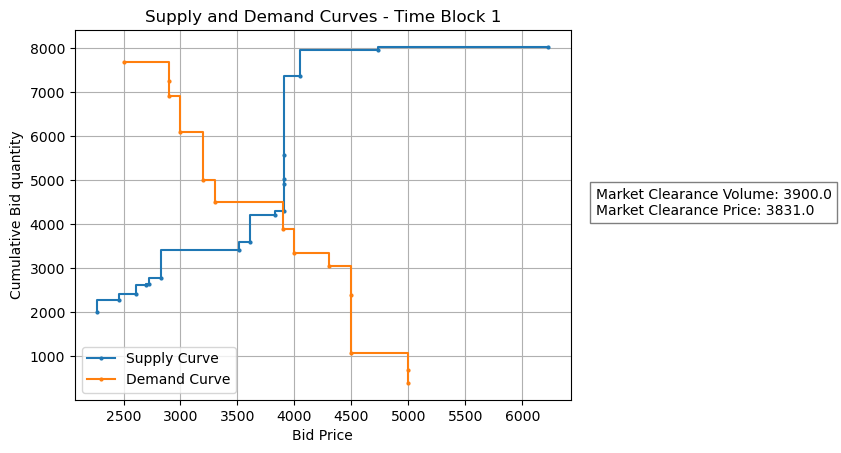

Supply Curve:
                 Company  Bid Price  Bid quantity  Cumulative Bid quantity
10            ANPARA TPS     2270.0       2000.00                  2000.00
5        ALMATTI DPH HPS     2460.0        290.00                  2290.00
2       AKRIMOTA LIG TPS     2610.0        125.00                  2415.00
9             ANPARA TPS     2700.0        210.00                  2625.00
0            AGARTALA GT     2721.0         21.00                  2646.00
7   ANANDPUR SAHIB-I HPS     2832.0        134.00                  2780.00
6     AMARKANTAK EXT TPS     3510.0        630.00                  3410.00
4    ALLAIN DUHANGAN HPS     3607.9        192.00                  3602.00
13           ANUPPUR TPP     3831.0        600.00                  4202.00
11             ANTA CCPP     3910.0         88.71                  4290.71
12             ANTA CCPP     3910.0        612.80                  4903.51
14          AURAIYA CCPP     3910.0        111.19                  5014.70
15         

In [11]:
I = 1
sell_cleared, buy_cleared ,objective_value , vol  = optimize_and_save(I, sell_bids, buy_bids)
price = plot_supply_demand(sell_cleared, buy_cleared ,I , vol)


#save_to_excel(sell_cleared, buy_cleared, I,objective_value, vol , price)

Maximizing Social welfare
for Time Block : 1
Objective value (Social welfare): 6659066.200000001

Total sell qty: 3900.0
Total buy qty: 3900.0
Market Clearance Volume: 3900.0

Market Clearance price: 3831.0


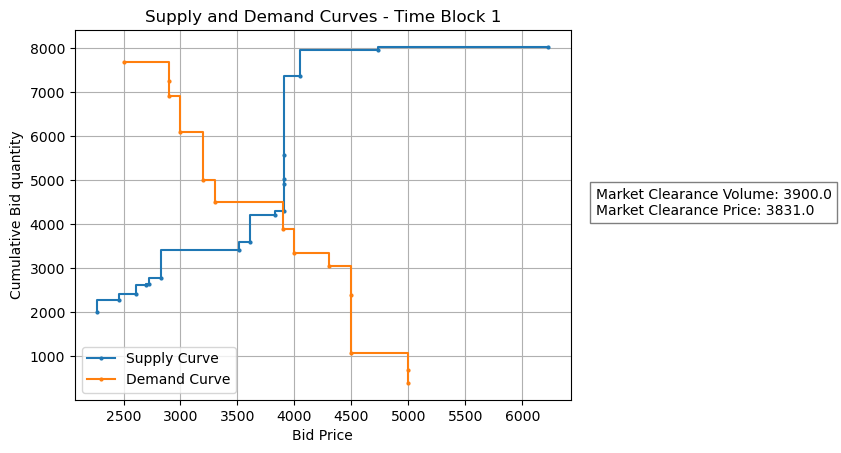

Supply Curve:
                 Company  Bid Price  Bid quantity  Cumulative Bid quantity
10            ANPARA TPS     2270.0       2000.00                  2000.00
5        ALMATTI DPH HPS     2460.0        290.00                  2290.00
2       AKRIMOTA LIG TPS     2610.0        125.00                  2415.00
9             ANPARA TPS     2700.0        210.00                  2625.00
0            AGARTALA GT     2721.0         21.00                  2646.00
7   ANANDPUR SAHIB-I HPS     2832.0        134.00                  2780.00
6     AMARKANTAK EXT TPS     3510.0        630.00                  3410.00
4    ALLAIN DUHANGAN HPS     3607.9        192.00                  3602.00
13           ANUPPUR TPP     3831.0        600.00                  4202.00
11             ANTA CCPP     3910.0         88.71                  4290.71
12             ANTA CCPP     3910.0        612.80                  4903.51
14          AURAIYA CCPP     3910.0        111.19                  5014.70
15         

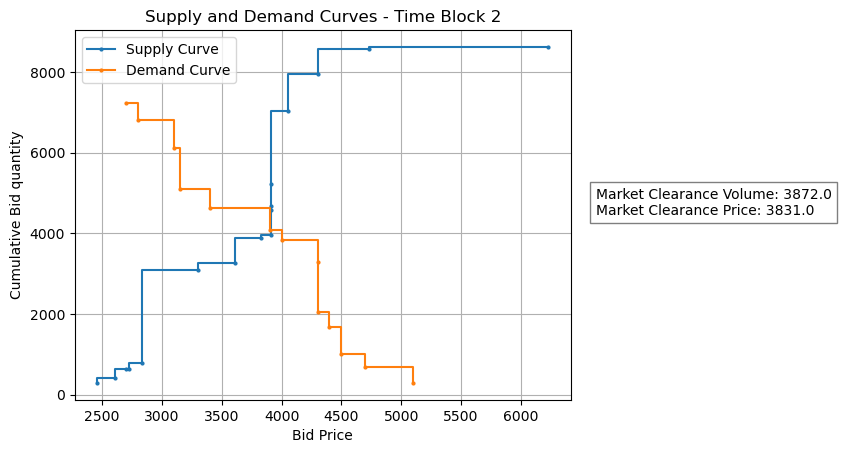

Supply Curve:
                 Company  Bid Price  Bid quantity  Cumulative Bid quantity
5        ALMATTI DPH HPS     2460.0        290.00                   290.00
2       AKRIMOTA LIG TPS     2610.0        125.00                   415.00
9             ANPARA TPS     2700.0        210.00                   625.00
0            AGARTALA GT     2721.0         21.00                   646.00
7   ANANDPUR SAHIB-I HPS     2832.0        134.00                   780.00
10            ANPARA TPS     3300.0       2300.00                  3080.00
4    ALLAIN DUHANGAN HPS     3607.9        192.00                  3272.00
13           ANUPPUR TPP     3831.0        600.00                  3872.00
11             ANTA CCPP     3910.0         88.71                  3960.71
12             ANTA CCPP     3910.0        612.80                  4573.51
14          AURAIYA CCPP     3910.0        111.19                  4684.70
15          AURAIYA CCPP     3910.0        546.50                  5231.20
1          

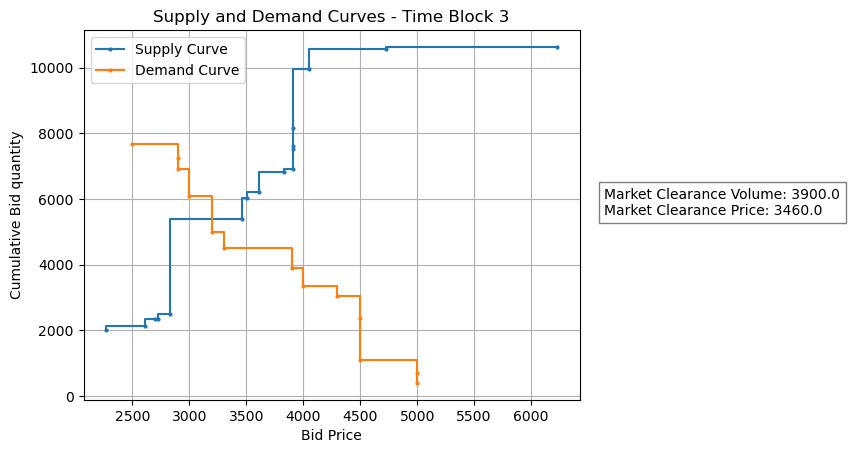

Supply Curve:
                 Company  Bid Price  Bid quantity  Cumulative Bid quantity
10            ANPARA TPS     2270.0       2000.00                  2000.00
2       AKRIMOTA LIG TPS     2610.0        125.00                  2125.00
9             ANPARA TPS     2700.0        210.00                  2335.00
0            AGARTALA GT     2721.0         21.00                  2356.00
7   ANANDPUR SAHIB-I HPS     2832.0        134.00                  2490.00
5        ALMATTI DPH HPS     3460.0       2900.00                  5390.00
6     AMARKANTAK EXT TPS     3510.0        630.00                  6020.00
4    ALLAIN DUHANGAN HPS     3607.9        192.00                  6212.00
13           ANUPPUR TPP     3831.0        600.00                  6812.00
11             ANTA CCPP     3910.0         88.71                  6900.71
12             ANTA CCPP     3910.0        612.80                  7513.51
14          AURAIYA CCPP     3910.0        111.19                  7624.70
15         

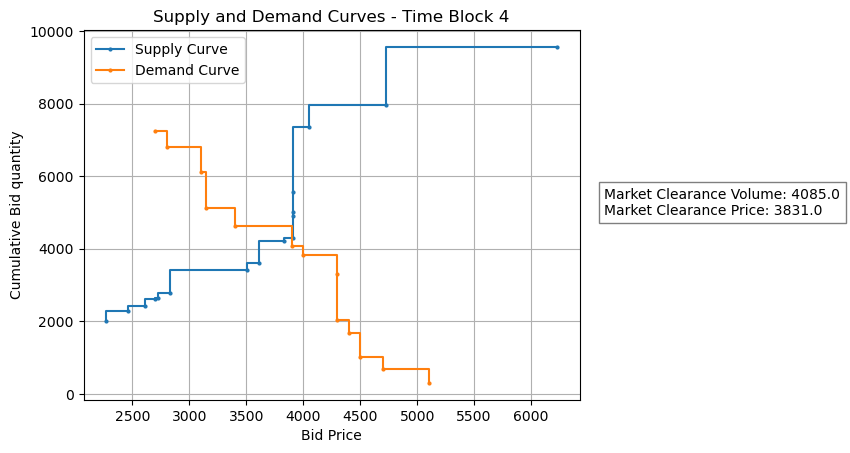

Supply Curve:
                 Company  Bid Price  Bid quantity  Cumulative Bid quantity
10            ANPARA TPS     2270.0       2000.00                  2000.00
5        ALMATTI DPH HPS     2460.0        290.00                  2290.00
2       AKRIMOTA LIG TPS     2610.0        125.00                  2415.00
9             ANPARA TPS     2700.0        210.00                  2625.00
0            AGARTALA GT     2721.0         21.00                  2646.00
7   ANANDPUR SAHIB-I HPS     2832.0        134.00                  2780.00
6     AMARKANTAK EXT TPS     3510.0        630.00                  3410.00
4    ALLAIN DUHANGAN HPS     3607.9        192.00                  3602.00
13           ANUPPUR TPP     3831.0        600.00                  4202.00
11             ANTA CCPP     3910.0         88.71                  4290.71
12             ANTA CCPP     3910.0        612.80                  4903.51
14          AURAIYA CCPP     3910.0        111.19                  5014.70
15         

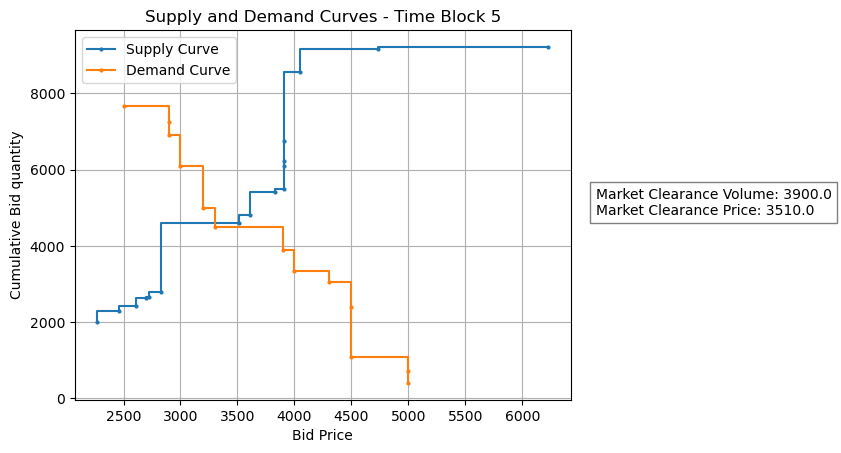

Supply Curve:
                 Company  Bid Price  Bid quantity  Cumulative Bid quantity
10            ANPARA TPS     2270.0       2000.00                  2000.00
5        ALMATTI DPH HPS     2460.0        290.00                  2290.00
2       AKRIMOTA LIG TPS     2610.0        125.00                  2415.00
9             ANPARA TPS     2700.0        210.00                  2625.00
0            AGARTALA GT     2721.0         21.00                  2646.00
7   ANANDPUR SAHIB-I HPS     2832.0        134.00                  2780.00
6     AMARKANTAK EXT TPS     3510.0       1830.00                  4610.00
4    ALLAIN DUHANGAN HPS     3607.9        192.00                  4802.00
13           ANUPPUR TPP     3831.0        600.00                  5402.00
11             ANTA CCPP     3910.0         88.71                  5490.71
12             ANTA CCPP     3910.0        612.80                  6103.51
14          AURAIYA CCPP     3910.0        111.19                  6214.70
15         

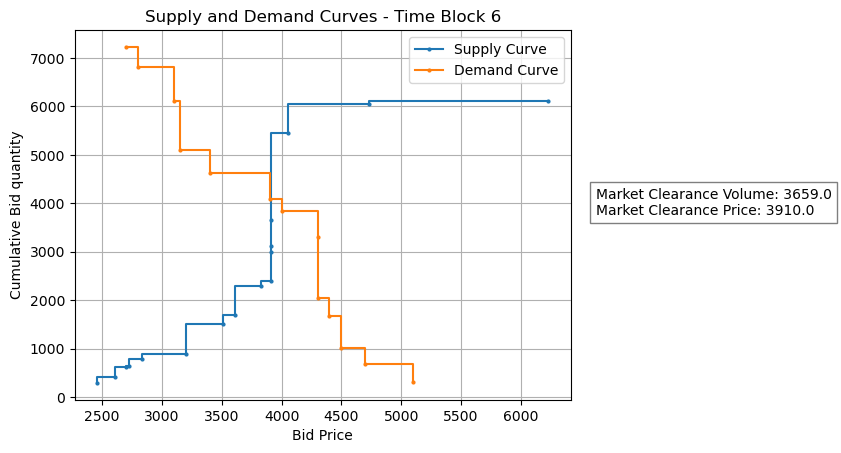

Supply Curve:
                 Company  Bid Price  Bid quantity  Cumulative Bid quantity
5        ALMATTI DPH HPS     2460.0        290.00                   290.00
2       AKRIMOTA LIG TPS     2610.0        125.00                   415.00
9             ANPARA TPS     2700.0        210.00                   625.00
0            AGARTALA GT     2721.0         21.00                   646.00
7   ANANDPUR SAHIB-I HPS     2832.0        134.00                   780.00
10            ANPARA TPS     3200.0        100.00                   880.00
6     AMARKANTAK EXT TPS     3510.0        630.00                  1510.00
4    ALLAIN DUHANGAN HPS     3607.9        192.00                  1702.00
13           ANUPPUR TPP     3831.0        600.00                  2302.00
11             ANTA CCPP     3910.0         88.71                  2390.71
12             ANTA CCPP     3910.0        612.80                  3003.51
14          AURAIYA CCPP     3910.0        111.19                  3114.70
15         

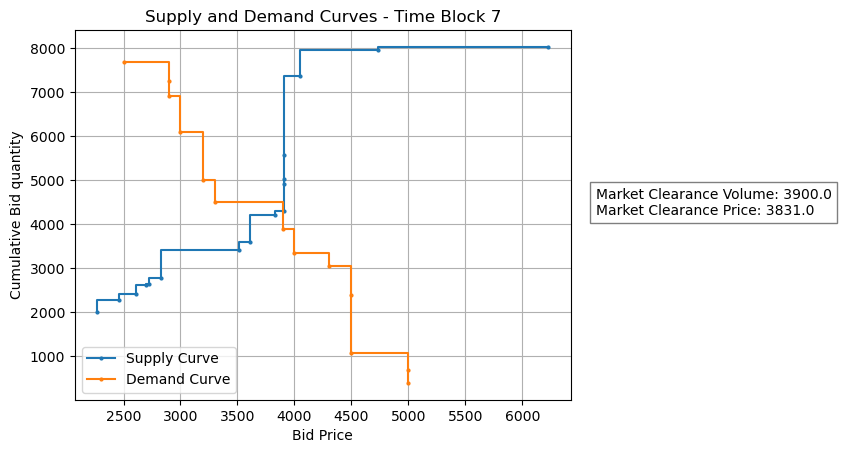

Supply Curve:
                 Company  Bid Price  Bid quantity  Cumulative Bid quantity
10            ANPARA TPS     2270.0       2000.00                  2000.00
5        ALMATTI DPH HPS     2460.0        290.00                  2290.00
2       AKRIMOTA LIG TPS     2610.0        125.00                  2415.00
9             ANPARA TPS     2700.0        210.00                  2625.00
0            AGARTALA GT     2721.0         21.00                  2646.00
7   ANANDPUR SAHIB-I HPS     2832.0        134.00                  2780.00
6     AMARKANTAK EXT TPS     3510.0        630.00                  3410.00
4    ALLAIN DUHANGAN HPS     3607.9        192.00                  3602.00
13           ANUPPUR TPP     3831.0        600.00                  4202.00
11             ANTA CCPP     3910.0         88.71                  4290.71
12             ANTA CCPP     3910.0        612.80                  4903.51
14          AURAIYA CCPP     3910.0        111.19                  5014.70
15         

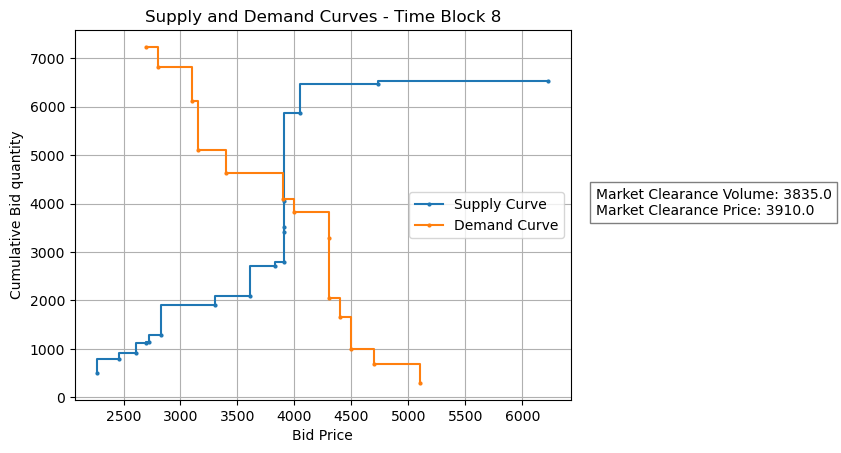

Supply Curve:
                 Company  Bid Price  Bid quantity  Cumulative Bid quantity
10            ANPARA TPS     2270.0        500.00                   500.00
5        ALMATTI DPH HPS     2460.0        290.00                   790.00
2       AKRIMOTA LIG TPS     2610.0        125.00                   915.00
9             ANPARA TPS     2700.0        210.00                  1125.00
0            AGARTALA GT     2721.0         21.00                  1146.00
7   ANANDPUR SAHIB-I HPS     2832.0        134.00                  1280.00
6     AMARKANTAK EXT TPS     3300.0        630.00                  1910.00
4    ALLAIN DUHANGAN HPS     3607.9        192.00                  2102.00
13           ANUPPUR TPP     3831.0        600.00                  2702.00
11             ANTA CCPP     3910.0         88.71                  2790.71
12             ANTA CCPP     3910.0        612.80                  3403.51
14          AURAIYA CCPP     3910.0        111.19                  3514.70
15         

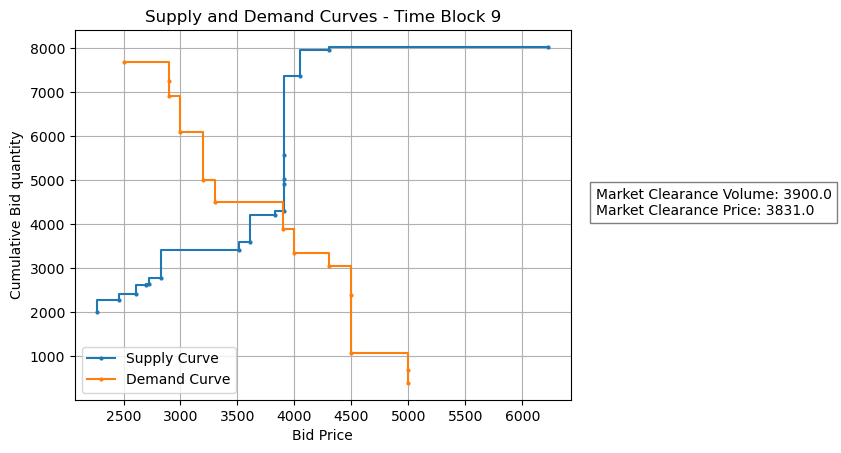

Supply Curve:
                 Company  Bid Price  Bid quantity  Cumulative Bid quantity
10            ANPARA TPS     2270.0       2000.00                  2000.00
5        ALMATTI DPH HPS     2460.0        290.00                  2290.00
2       AKRIMOTA LIG TPS     2610.0        125.00                  2415.00
9             ANPARA TPS     2700.0        210.00                  2625.00
0            AGARTALA GT     2721.0         21.00                  2646.00
7   ANANDPUR SAHIB-I HPS     2832.0        134.00                  2780.00
6     AMARKANTAK EXT TPS     3510.0        630.00                  3410.00
4    ALLAIN DUHANGAN HPS     3607.9        192.00                  3602.00
13           ANUPPUR TPP     3831.0        600.00                  4202.00
11             ANTA CCPP     3910.0         88.71                  4290.71
12             ANTA CCPP     3910.0        612.80                  4903.51
14          AURAIYA CCPP     3910.0        111.19                  5014.70
15         

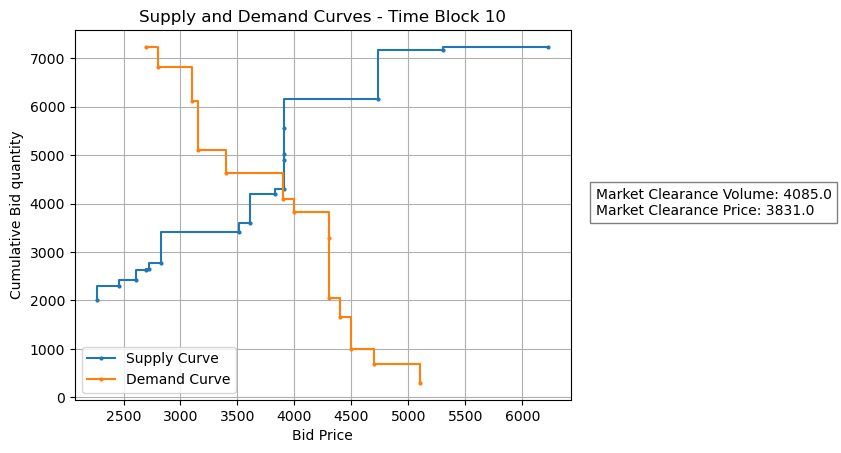

Supply Curve:
                 Company  Bid Price  Bid quantity  Cumulative Bid quantity
10            ANPARA TPS     2270.0       2000.00                  2000.00
5        ALMATTI DPH HPS     2460.0        290.00                  2290.00
2       AKRIMOTA LIG TPS     2610.0        125.00                  2415.00
9             ANPARA TPS     2700.0        210.00                  2625.00
0            AGARTALA GT     2721.0         21.00                  2646.00
7   ANANDPUR SAHIB-I HPS     2832.0        134.00                  2780.00
6     AMARKANTAK EXT TPS     3510.0        630.00                  3410.00
4    ALLAIN DUHANGAN HPS     3607.9        192.00                  3602.00
13           ANUPPUR TPP     3831.0        600.00                  4202.00
11             ANTA CCPP     3910.0         88.71                  4290.71
12             ANTA CCPP     3910.0        612.80                  4903.51
14          AURAIYA CCPP     3910.0        111.19                  5014.70
15         

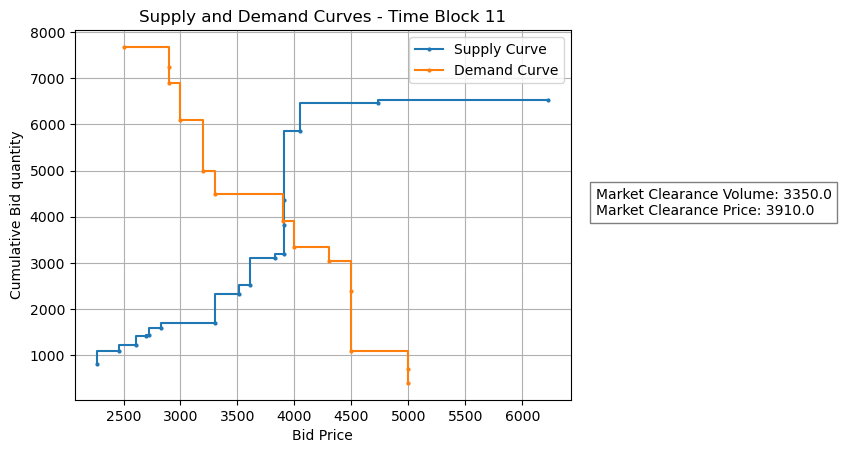

Supply Curve:
                 Company  Bid Price  Bid quantity  Cumulative Bid quantity
10            ANPARA TPS     2270.0        800.00                   800.00
5        ALMATTI DPH HPS     2460.0        290.00                  1090.00
2       AKRIMOTA LIG TPS     2610.0        125.00                  1215.00
9             ANPARA TPS     2700.0        210.00                  1425.00
0            AGARTALA GT     2721.0         21.00                  1446.00
7   ANANDPUR SAHIB-I HPS     2832.0        134.00                  1580.00
14          AURAIYA CCPP     3300.0        111.19                  1691.19
6     AMARKANTAK EXT TPS     3510.0        630.00                  2321.19
4    ALLAIN DUHANGAN HPS     3607.9        192.00                  2513.19
13           ANUPPUR TPP     3831.0        600.00                  3113.19
11             ANTA CCPP     3910.0         88.71                  3201.90
12             ANTA CCPP     3910.0        612.80                  3814.70
15         

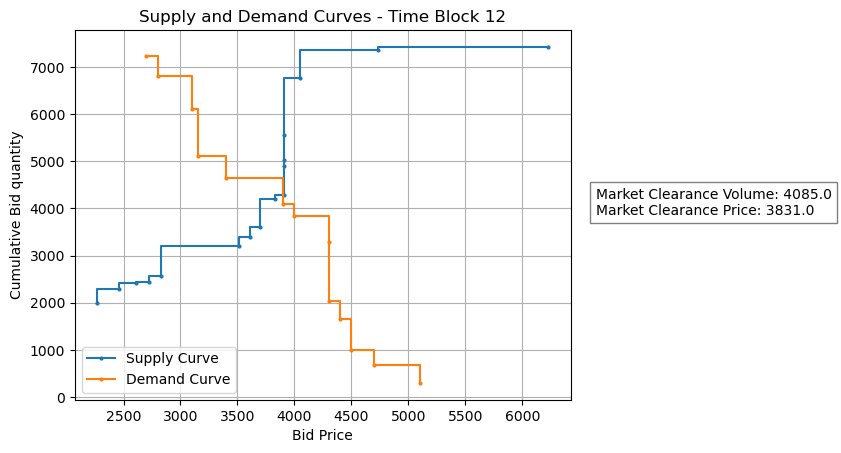

Supply Curve:
                 Company  Bid Price  Bid quantity  Cumulative Bid quantity
10            ANPARA TPS     2270.0       2000.00                  2000.00
5        ALMATTI DPH HPS     2460.0        290.00                  2290.00
2       AKRIMOTA LIG TPS     2610.0        125.00                  2415.00
0            AGARTALA GT     2721.0         21.00                  2436.00
7   ANANDPUR SAHIB-I HPS     2832.0        134.00                  2570.00
6     AMARKANTAK EXT TPS     3510.0        630.00                  3200.00
4    ALLAIN DUHANGAN HPS     3607.9        192.00                  3392.00
9             ANPARA TPS     3700.0        210.00                  3602.00
13           ANUPPUR TPP     3831.0        600.00                  4202.00
11             ANTA CCPP     3910.0         88.71                  4290.71
12             ANTA CCPP     3910.0        612.80                  4903.51
14          AURAIYA CCPP     3910.0        111.19                  5014.70
15         

In [12]:
for I in range(1,12+1):
    sell_cleared, buy_cleared ,objective_value, vol  = optimize_and_save(I, sell_bids, buy_bids)
    price = plot_supply_demand(sell_cleared, buy_cleared,I , vol)

    save_to_excel(sell_cleared, buy_cleared, I,objective_value, vol , price)
    print("------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------")